#follow this to install prismnet
https://github.com/kuixu/PrismNet

In [1]:
!pip install pyBigWig

You should consider upgrading via the '/opt/conda/bin/python3.9 -m pip install --upgrade pip' command.


In [ ]:
signal = 'COV'

In [2]:
import pyBigWig
import numpy as np

class strand_specific_wig:
    def __init__(self, plus, minus):
        self.plus = pyBigWig.open(plus)
        self.minus = pyBigWig.open(minus)
        
    def fetch(self, chrom = None, start= None, end=None, strand= None, interval = None):
        ''' return icSHAPE reacitivity for a bedtool interval or chrom, start, end, strand'''
        if interval:
            start = interval.start
            end = interval.end
            strand = interval.strand
            chrom = interval.chrom
        if strand == '-':
            icshape_data = self.minus
        else:
            icshape_data = self.plus
        values = icshape_data.values(chrom, start, end)
        if strand == '-':
            values = values[::-1]
        return np.nan_to_num(np.array(values), 0)


In [3]:
import argparse, os, random
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler



from sklearn import metrics
import numpy as np

import prismnet.model as arch
from prismnet import train, validate, inference, log_print, compute_saliency, compute_saliency_img, compute_high_attention_region
#compute_high_attention_region

# from prismnet.engine.train_loop import 
from prismnet.model.utils import GradualWarmupScheduler
from prismnet.loader import SeqicSHAPE
from prismnet.utils import datautils

In [4]:
# # out dir

# identity   = args.p_name+'_'+args.arch+"_"+args.mode # 441_PUM2_K562_sub4509_PrismNet_pu.metrics
# datautils.make_directory(args.out_dir,"out/")
# model_dir  = datautils.make_directory(args.out_dir,"out/models")
# model_path = os.path.join(model_dir, identity+"_{}.pth")

# if args.tfboard:
#     tfb_dir  = datautils.make_directory(args.out_dir,"out/tfb")
#     writer = SummaryWriter(tfb_dir)
# else:
#     writer = None
# # fix random seed
# fix_seed(args.seed)

In [5]:
import pandas as pd
outstem = 'K562_rep6'
megaoutput = pd.read_csv(f'../data/ABC_data/{outstem}.megaoutputs_masked.tsv', sep = '\t')
seq = pd.read_csv(f'../data/ABC_data/tsv/{outstem}.DDX3.tsv', sep = '\t', names = ['chrom', 'name', 
                                                                                 'seq', 'struct', 'label', 'start'])

In [6]:
max_length=seq['seq'].str.len().max()

In [7]:
from prismnet.utils import datautils

In [8]:
def fetch_cits(megaoutput, rbp, max_length=None):
    """convert DNA/RNA sequences to a one-hot representation"""
    
    rbp_wig_cits = strand_specific_wig(f'../data/{signal}/{rbp}.pos.bw',
                                     f'../data/{signal}/{rbp}.neg.bw'
                                                               )

    data = []
    for index, row in megaoutput.iterrows():
        wig_values_cits = rbp_wig_cits.fetch(row['chrom'], row['start'], row['end'], row['strand'])
        seq_length = len(wig_values_cits)
        
    
        # handle boundary conditions with zero-padding
        if max_length:
            offset1 = int((max_length - seq_length)/2)
            offset2 = max_length - seq_length - offset1

            if offset1:
                wig_values_cits = np.hstack([np.zeros((offset1)), wig_values_cits])
            if offset2:
                wig_values_cits = np.hstack([wig_values_cits, np.zeros((offset2))])
        if np.any(wig_values_cits < 0):
            wig_values_cits = -wig_values_cits
        data.append(wig_values_cits)

    # convert to numpy array
    data = np.array(data).astype(np.int32)

    return data

In [9]:
one_hot = datautils.convert_one_hot(seq['seq'], max_length)

In [10]:
one_hot.shape # N, 4, max_length

(138498, 4, 100)

In [11]:
data = one_hot

In [12]:
# targets: predict binary
target_col = megaoutput.columns[(megaoutput.columns.str.startswith('logLR'))&(megaoutput.columns.str.contains(outstem))]
target_df = megaoutput[target_col]

<AxesSubplot:>

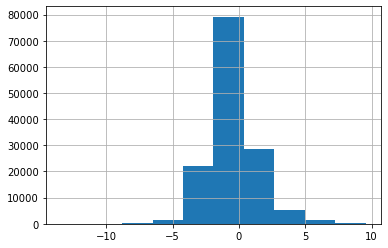

In [13]:
target_df[f'logLR:{outstem}.IGF2BP2'].hist()

<AxesSubplot:>

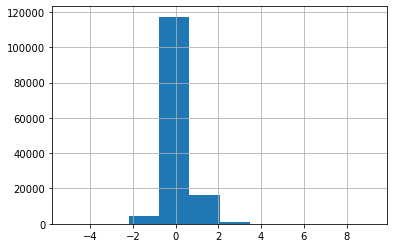

In [14]:
target_df[f'logLR:{outstem}.PUM2'].hist()

In [15]:
targets = target_df.values
targets.shape

(138498, 10)

In [16]:
target_col

Index(['logLR:K562_rep6.IGF2BP2', 'logLR:K562_rep6.RBFOX2',
       'logLR:K562_rep6.PUM2', 'logLR:K562_rep6.FAM120A',
       'logLR:K562_rep6.DDX3', 'logLR:K562_rep6.ZC3H11A',
       'logLR:K562_rep6.EIF3G', 'logLR:K562_rep6.PRPF8',
       'logLR:K562_rep6.LIN28B', 'logLR:K562_rep6.SF3B4'],
      dtype='object')

In [17]:
# BP target
cits_target = []
for col in target_col:
    rbp = col.split('.')[-1]
    cits = fetch_cits(megaoutput, rbp, max_length)
    cits_target.append(cits)

In [18]:
cits_target = np.stack(cits_target, axis = -1)


In [19]:
np.save(f'../data/{signal}/{outstem}.cits_cnt.npz', cits_target)

In [20]:
cits_target.max()

53

(0.0, 1000.0)

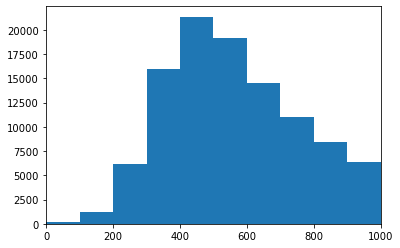

In [26]:
import matplotlib.pyplot as plt
plt.hist(cits_target.sum(axis = -1).sum(axis = -1),range = (0,1000))
plt.xlim(0,1000)